# Offline Analysis - verdicts generated by metadata checking

In this document, we will explain how the script for the analysis of verdicts generated by metadata checking uses data collected at runtime to create a visual display of the observed time taken by a run along a subpath.

## Importing modules

First, let's import the modules we will need and set the path to server and the monitored service. The $\small\texttt{va.prepare("verdicts.db")}$ command sets up the verdict server side containing the database in the background. Since it takes some time to start running, we have to poll it until it responds in order to make sure that the connection is set up before we try to perform the analysis.

The name of the database which stores performance data is, in this case, 'verdicts.db'. However, in general, the server can be started based on any other available database, provided that it is reachable by an SQLite connection, by simply calling this function with the string (the name of that database) as an argument.

In [1]:
import sys
import ast
import pprint

%matplotlib inline
import matplotlib
#matplotlib.use('agg')
#uncomment previous line if it's running for the first time?
import matplotlib.pyplot as plt
from dateutil.parser import isoparse
import traceback
import json
import argparse

import VyPRAnalysis as va
va.prepare("verdicts.db")
va.set_monitored_service_path("uploader-experiments/uploader/")

from VyPR.SCFG.parse_tree import ParseTree

Failed to connect to server.
Connected to server


## Observed times for different paths 

The following section of code begins with fetching a list of functions from the database and selecting the function $\small{\texttt{server-app.metadata_handler_MetadataHandler:__init__}}$ (creating an object instance representing this function with the corresponding attributes' values). We also need its symbolic control-flow graph, the object representing a directed graph, whose structure is derived from the source code being monitored by VyPR. This object will be important for reconstructing the paths taken. 

The next step is to iterate through all the calls of this function and the failed verdicts detected during each call and compare two different subpaths in terms of the observed time taken for the program run along each subpath. More precisely, for every such verdict, we take two observations - each storing the data about the recorded value of the specified property of interest (i.e. duration). Sorting them by the value of $\small\texttt{sub_index}$ (in ascending order) ensures that the left-hand side path always refers to the observation with the sub-index value 0, which is recorded first. The $\small\texttt{rhs_path}$ stores the path taken to the point that happens later during the run, and it is the time between those two events that we want to analyse. Both paths contain the part of the run between the beginning of the run and the first observation (this is exactly what is stored in the LHS path, but the RHS also contains the rest of the path up to the second observation). Using the path difference to get the subpath taken between those two points and the grammar derived from the SCFG, it is possible to construct a parse tree with the information about the path between the two observations.

The most important output of this section is the list of parse trees which record the paths and the intersection of those trees.

Note that the execution of this code can take a couple of minutes.

In [2]:
metadata_function = va.list_functions()[2]
prop = metadata_function.get_properties()[0]

scfg = metadata_function.get_scfg()
grammar = scfg.derive_grammar()

calls = metadata_function.get_calls()
n_of_calls = len(calls)


parse_trees_obs_value_pairs = []

print("Starting the iteration through the calls list, total: %i" % n_of_calls)

for (n, call) in enumerate(calls):
  if n%100 == 0:
    print("Processed %i/%i calls." % (n, n_of_calls))
  verdicts = call.get_verdicts(property = prop.hash)
  for verdict in verdicts:
    if verdict.binding == 3 and verdict.verdict == 0:
      observations = sorted(verdict.get_observations(), key=lambda obs : obs.sub_index)
      try:
        lhs_path = observations[0].reconstruct_reaching_path(scfg)
        rhs_path = observations[1].reconstruct_reaching_path(scfg)
        path_difference = rhs_path[len(lhs_path):]
        parse_tree = ParseTree(path_difference, grammar, path_difference[0]._source_state)
        lhs_time = isoparse(ast.literal_eval(observations[0].observed_value)["time"])
        rhs_time = isoparse(ast.literal_eval(observations[1].observed_value)["time"])
        time_taken = (rhs_time - lhs_time).total_seconds()
        
        parse_trees_obs_value_pairs.append((parse_tree, time_taken))
      except:
        pass
      

parse_trees, times = zip(*parse_trees_obs_value_pairs)

intersection = parse_trees[0].intersect(parse_trees[1:])

print("Done.")

Starting the iteration through the calls list, total: 3910
Processed 0/3910 calls.
Processed 100/3910 calls.
Processed 200/3910 calls.
Processed 300/3910 calls.
Processed 400/3910 calls.
Processed 500/3910 calls.
Processed 600/3910 calls.
Processed 700/3910 calls.
Processed 800/3910 calls.
Processed 900/3910 calls.
Processed 1000/3910 calls.
Processed 1100/3910 calls.
Processed 1200/3910 calls.
Processed 1300/3910 calls.
Processed 1400/3910 calls.
Processed 1500/3910 calls.
Processed 1600/3910 calls.
Processed 1700/3910 calls.
Processed 1800/3910 calls.
Processed 1900/3910 calls.
Processed 2000/3910 calls.
Processed 2100/3910 calls.
Processed 2200/3910 calls.
Processed 2300/3910 calls.
Processed 2400/3910 calls.
Processed 2500/3910 calls.
Processed 2600/3910 calls.
Processed 2700/3910 calls.
Processed 2800/3910 calls.
Processed 2900/3910 calls.
Processed 3000/3910 calls.
Processed 3100/3910 calls.
Processed 3200/3910 calls.
Processed 3300/3910 calls.
Processed 3400/3910 calls.
Processe

Now we are ready to construct a simple dictionary, the keys of which will be 0 and 1 - each representing the index of the subpath taken to generate the corresponding observation. Values that belong to them are lists containing the observed durations. We begin with getting the paths through the intersection parse tree to any path parameters.

In [3]:
path_parameters = []
intersection.get_parameter_paths(intersection._root_vertex, [], path_parameters)

parameter_value_indices_to_times = {}
subpaths = []

n_of_trees = len(parse_trees)
for (n, parse_tree) in enumerate(parse_trees):
  subtree = parse_tree.get_parameter_subtree(path_parameters[0])
  subpath = subtree.read_leaves()
  if subpath in subpaths:
    subpath_index = subpaths.index(subpath)
  else:
    subpaths.append(subpath)
    subpath_index = len(subpaths)-1
  if subpath_index not in parameter_value_indices_to_times:
    parameter_value_indices_to_times[subpath_index] = [times[n]]
  else:
    parameter_value_indices_to_times[subpath_index].append(times[n])



## Plotting observed times for each subpath

Finally, we have everything needed for creating the two plots shown below. The lists with the observed durations mentioned in the previous section are the measurement of interest. We are plotting these values vs their index.

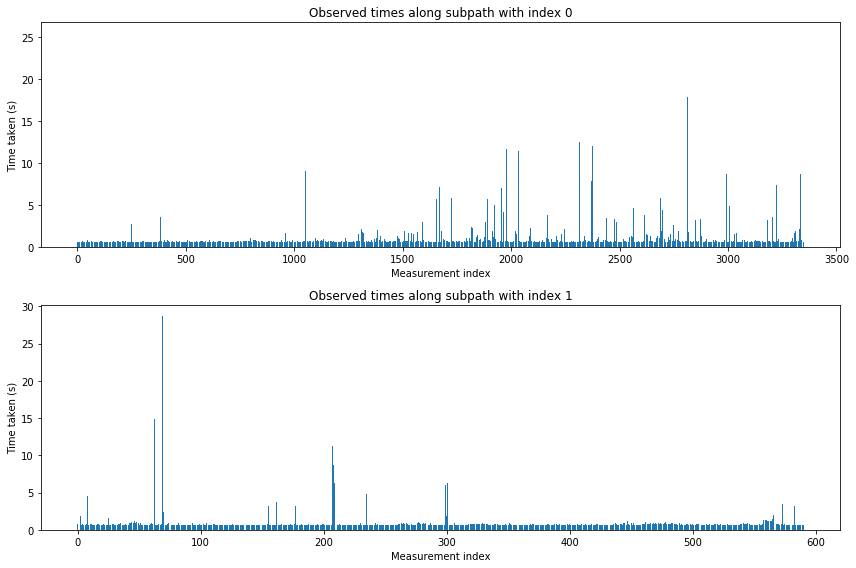

In [4]:
fig, (ax1, ax2) = plt.subplots(2)

fig.set_figheight(8)
fig.set_figwidth(12)

ax1.set_title("Observed times along subpath with index 0")
ax1.set_xlabel("Measurement index")
ax1.set_ylabel("Time taken (s)")
ax1.bar(
  range(len(parameter_value_indices_to_times[0])),
  parameter_value_indices_to_times[0]
)

ax2.set_title("Observed times along subpath with index 1")
ax2.set_xlabel("Measurement index")
ax2.set_ylabel("Time taken (s)")
ax2.bar(
  range(len(parameter_value_indices_to_times[1])),
  parameter_value_indices_to_times[1]
)

fig.tight_layout()

plt.show()

## Terminating the server

When you shut down the notebook, the subprocess which runs the server should stop automatically, but in case you want to shut the server down manually, use the following line:

In [5]:
va.teardown()